In [2]:
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

from descriptor_index_pb2 import DescriptorIndex
from debug_fusion_pb2 import DebugFusion
from utils import plot_imgs
%load_ext autoreload
%autoreload 2
%matplotlib inline

INDEX_ROOT = '../deep-relocalization/data/'
MAP_ROOT = '../deep-relocalization/maps/'

In [3]:
def get_index(name):
    index = DescriptorIndex()
    with open(Path(INDEX_ROOT, name).as_posix(), 'rb') as f:
        index.ParseFromString(f.read())
    return index
def get_debug_data(name):
    debug = DebugFusion()
    with open(Path(INDEX_ROOT, 'loc_debug', name).as_posix(), 'rb') as f:
        debug.ParseFromString(f.read())
    return debug
def get_data_from_index(index):
    positions = np.stack([f.position_vector.data for f in index.frames])
    rotations = np.stack([np.reshape(f.rotation_matrix.data, (3, 3), order='C') for f in index.frames])
    descriptors = np.stack([f.global_descriptor.data for f in index.frames])
    resources = np.stack([f.resource_name for f in index.frames])
    ids = [f.vertex_id for f in index.frames]
    return {'pos': positions, 'rot': rotations, 'descriptors': descriptors, 'res': resources, 'ids': ids}
def get_image(index, i):
    root = Path(MAP_ROOT, index.data_name.split('/')[-1], 'resources/raw_images/')
    return cv2.imread(Path(root, '%s.pgm' % index.frames[i].resource_name).as_posix())

In [4]:
ref_index = get_index('lindenhof_afternoon_aligned_mobilenet-d0.35.pb')
query_index = get_index('lindenhof_wet_aligned_mobilenet-d0.35.pb')
ref_poses = get_data_from_index(ref_index)
query_poses = get_data_from_index(query_index)
num_queries = len(query_poses['pos'])

In [5]:
def get_loc_error(name):
    loc_data_our = get_debug_data(name)
    ok_queries = [q for q in loc_data_our.query_components if q.status != 'fail']
    loc_pos = np.stack([q.pnp_position.data for q in ok_queries])
    gt_pos = np.stack([q.gt_position.data for q in ok_queries])
    loc_error = np.linalg.norm(gt_pos - loc_pos, axis=-1)
    query_ids = [q.query_id for q in ok_queries]
    return loc_error, loc_pos, gt_pos, query_ids
def plot_loc_error(loc_error, max_error=5):
    errors = np.linspace(0, max_error)
    tp = loc_error[np.newaxis, :] < errors[:, np.newaxis]
    recall = np.sum(tp, axis=1) / num_queries
    return errors, recall

In [80]:
expers = [
#    'loc_mobilenet-d0.35-pca512-NN5_sift.pb', 
#    'loc_mobilenet-d0.35-pca512-NN10_sift.pb',
#    'loc_mobilenet-d0.35-pca512-NN20_sift.pb',
    'loc_mobilenet-d0.35-pca512-NN10_sift-eps0.5.pb',
    'loc_mobilenet-d0.35-pca512-NN10_sift.pb',
    'loc_mobilenet-d0.35-pca512-NN10_sift-eps6.pb',
    'loc_mobilenet-d0.35-pca512-NN10_sift-eps9.pb',
]
error_thresh = 0.1
for exp in expers:
    error, l, gt, _ = get_loc_error(exp)
    recall = np.sum(error < error_thresh)/num_queries
    print('{n:<45} {r:.1f} Recall@{et}m | {me:.3f}m Median err. '.format(
        n=exp, r=100*recall, et=error_thresh, me=np.median(error)))

loc_mobilenet-d0.35-pca512-NN10_sift-eps0.5.pb 38.6 Recall@0.1m | 0.029m Median err. 
loc_mobilenet-d0.35-pca512-NN10_sift.pb       38.5 Recall@0.1m | 0.029m Median err. 
loc_mobilenet-d0.35-pca512-NN10_sift-eps6.pb  36.3 Recall@0.1m | 0.032m Median err. 
loc_mobilenet-d0.35-pca512-NN10_sift-eps9.pb  32.9 Recall@0.1m | 0.035m Median err. 


loc_mobilenet-d0.35-pca512-NN5_sift.pb        38.4 Recall@0.1m | 0.031m Median err. 
loc_mobilenet-d0.35-pca512-NN10_sift.pb       38.5 Recall@0.1m | 0.029m Median err. 
loc_mobilenet-d0.35-pca512-NN20_sift.pb       38.8 Recall@0.1m | 0.027m Median err. 


loc_baseline-freak.pb                         20.1 Recall@0.1m | 71.1 Precision@0.1m | 0.048m Median err. | 27.4
loc_mobilenet-d0.35-pca512-NN10_sift.pb       38.5 Recall@0.1m | 80.5 Precision@0.1m | 0.029m Median err. | 47.4
loc_mobilenet-d0.35-pca512-NN20_sift.pb       38.8 Recall@0.1m | 81.9 Precision@0.1m | 0.027m Median err. | 46.9


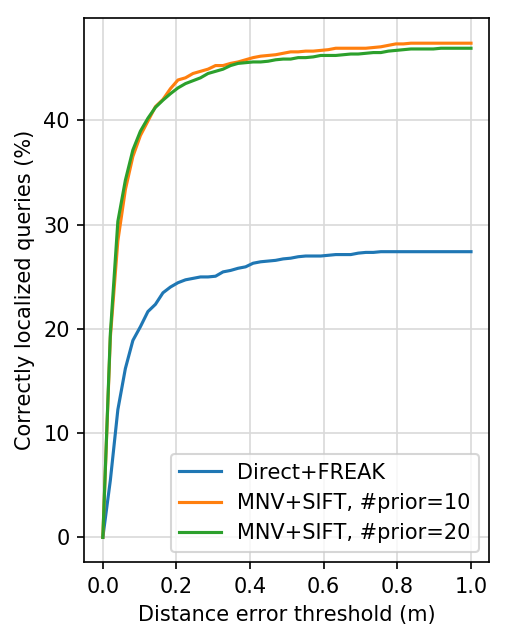

In [106]:
plt.figure(figsize=(3.6, 4.8), dpi=150)
error_thresh = 0.1
expers = [
    'loc_baseline-freak.pb',
#    'loc_mobilenet-d0.35-pca512-NN10_freak-NN2.pb',
    'loc_mobilenet-d0.35-pca512-NN10_sift.pb',
    'loc_mobilenet-d0.35-pca512-NN20_sift.pb', 
#    'loc_mobilenet-d0.35-pca512-NN5_sift.pb', 
#    'loc_netvlad-pca128-NN10_sift.pb',
#    'loc_perfect-NN10_sift_thresh30.pb',
]
names = [         
    'Direct+FREAK',
#    'MNV+FREAK, #prior=10',
    'MNV+SIFT, #prior=10',
    'MNV+SIFT, #prior=20',
#    'Perfect, #prior=10',
]
for exp, name in zip(expers, names):
    error, l, gt, _ = get_loc_error(exp)
    e, r = plot_loc_error(error, max_error=1)
    plt.plot(e, r*100, label=name);
    recall = np.sum(error < error_thresh)/num_queries
    precision = np.mean(error < error_thresh)
    print('{n:<45} {r:.1f} Recall@{et}m | {p:.1f} Precision@{et}m | {me:.3f}m Median err. | {rm:.1f}'.format(
        n=exp, r=100*recall, et=error_thresh, p=100*precision, me=np.median(error), rm=100*r[-1]))
plt.grid(color=[0.85]*3); plt.legend(loc=0); plt.gcf().subplots_adjust(left=0.15)
#plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
plt.xlabel('Distance error threshold (m)'), plt.ylabel('Correctly localized queries (%)');
plt.savefig('plots/cumulative_error_v3.pdf', format='pdf')

loc_mobilenet-d0.35-pca512-NN10_sift.pb            0.385 Recall@0.1m, 0.805 Precision@0.1m, 0.029m Median error
loc_mobilenet-d0.35-pca512-NN20_sift.pb            0.388 Recall@0.1m, 0.819 Precision@0.1m, 0.027m Median error
loc_perfect-NN10_sift.pb                           0.388 Recall@0.1m, 0.812 Precision@0.1m, 0.031m Median error
loc_baseline-freak.pb                              0.201 Recall@0.1m, 0.711 Precision@0.1m, 0.048m Median error


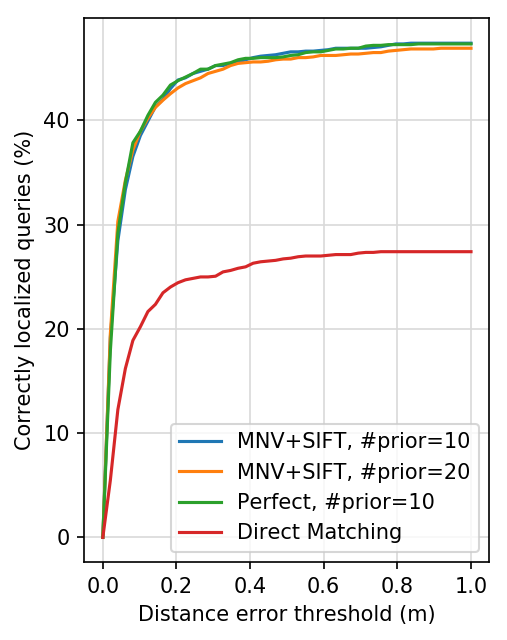

loc_mobilenet-d0.35-pca128-NN10_sift.pb            0.387 Recall@0.1m, 0.818 Precision@0.1m, 0.030m Median error
loc_mobilenet-d0.35-pca128-NN20_sift.pb            0.392 Recall@0.1m, 0.813 Precision@0.1m, 0.032m Median error
loc_netvlad-pca128-NN10_sift.pb                    0.387 Recall@0.1m, 0.821 Precision@0.1m, 0.028m Median error
loc_baseline-freak.pb                              0.201 Recall@0.1m, 0.711 Precision@0.1m, 0.048m Median error


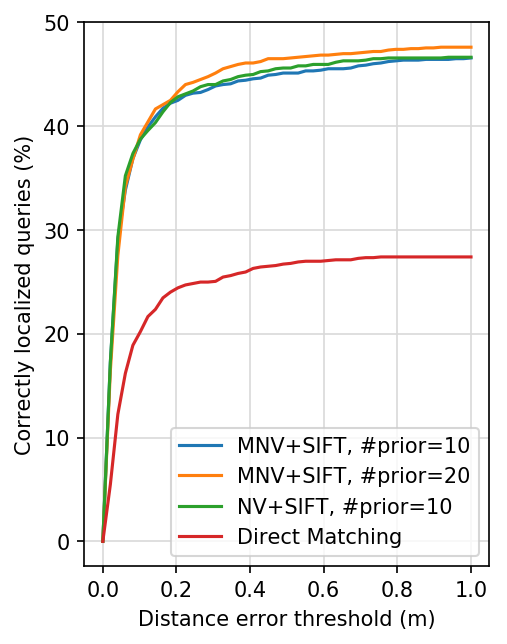

In [ ]:
plt.figure(figsize=(4.8, 4.8 ), dpi=150)
num_neighbors = 10
exper = 'loc_mobilenet-d0.35-pca128-NN10_sift.pb'
dims = [32, 64, 128, 256, 1024, 0]
for exp, name in zip(expers, names):
    error, l, gt, _ = get_loc_error(exp)
    e, r = plot_loc_error(error, max_error=1)
    plt.plot(e, r*100, label=name);
    recall = np.sum(error < error_thresh)/num_queries
    precision = np.mean(error < error_thresh)
    print('{n:<50} {r:.3f} Recall@{et}m, {p:.3f} Precision@{et}m, {me:.3f}m Median error'.format(
        n=exp, r=recall, et=error_thresh, p=precision, me=np.median(error)))
plt.grid(color=[0.85]*3); plt.legend(loc=0); plt.gcf().subplots_adjust(left=0.15)
#plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
plt.xlabel('Distance error threshold (m)'), plt.ylabel('Correctly localized queries (%)');
plt.savefig('plots/cumulative_error.pdf', format='pdf')

In [102]:
stats = get_debug_data('loc_mobilenet-d0.35-pca128-NN10_sift.pb')
np.mean([q.num_inliers for q in stats.query_components if q.status != 'fail'])

45.557833089311856

In [103]:
stats = get_debug_data('loc_baseline-freak.pb')
np.mean([q.num_inliers for q in stats.query_components if q.status != 'fail'])

25.731051344743275

In [38]:
loc_error, loc_pos, gt_pos, ids = get_loc_error('loc_mobilenet-d0.35-pca512-NN10_sift.pb')
is_good_loc = loc_error < 0.5
good_loc = loc_pos[is_good_loc]
bad_loc = loc_pos[np.logical_not(is_good_loc)]
gt_loc = gt_pos[np.logical_not(is_good_loc)]

(0.46505190311418687, 0.01384083044982699)

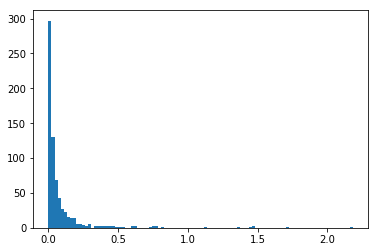

In [34]:
plt.hist(loc_error, bins=100)
len(good_loc) / num_queries, len(bad_loc) / num_queries

/home/psarlin/PLR/Deep-Relocalization/env/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


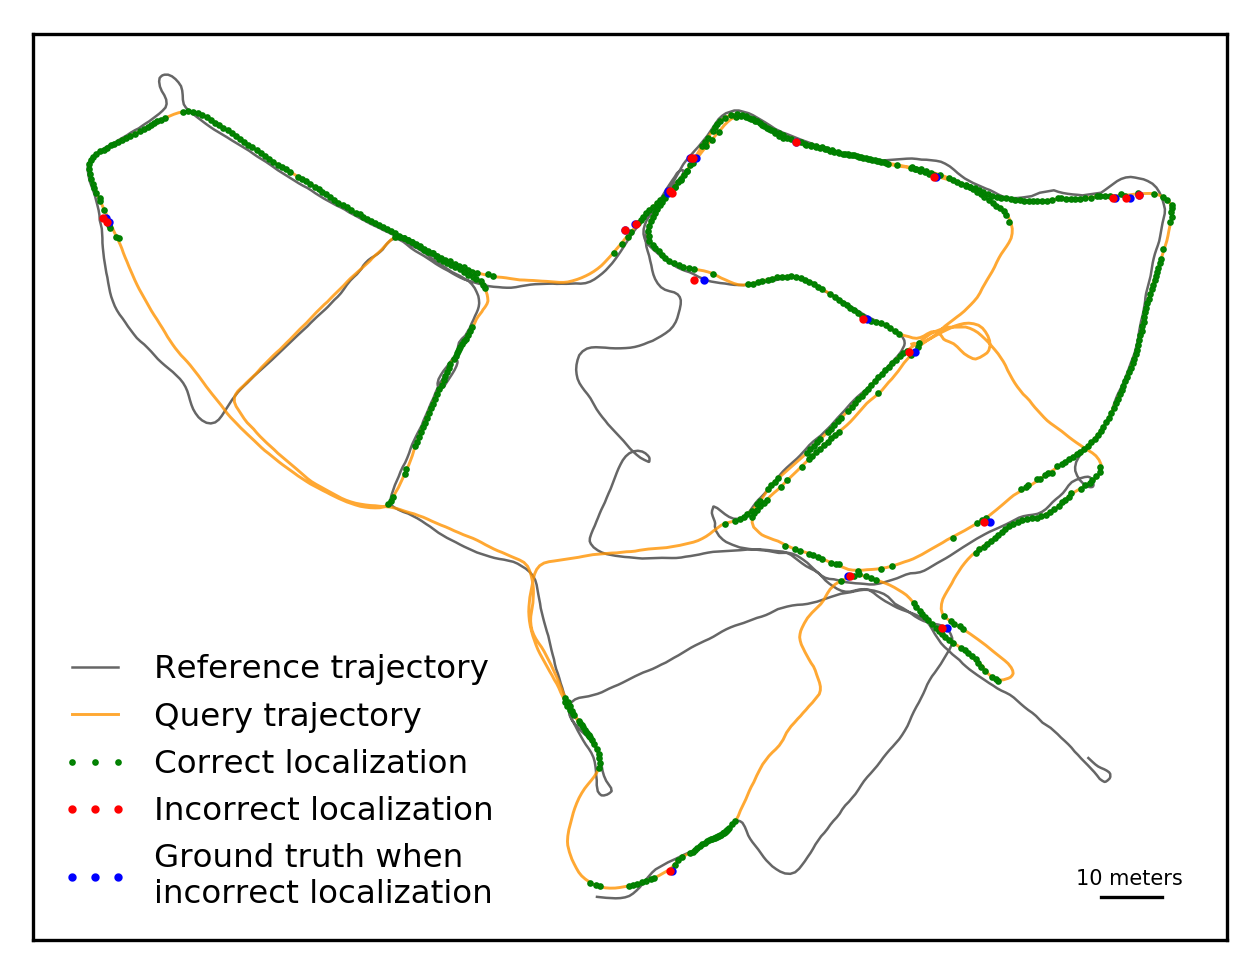

In [94]:
plt.figure(dpi=300)
plt.plot(ref_poses['pos'][:, 1], -ref_poses['pos'][:, 0], linewidth=0.6, color='k', alpha=0.6,
         label='Reference trajectory', zorder=1);
plt.plot(query_poses['pos'][:, 1], -query_poses['pos'][:, 0], linewidth=0.7, color='#FF9300', alpha=0.8,
         label='Query trajectory', zorder=2);
plt.axes().set_aspect('equal'); plt.tick_params(axis='both',labelsize=6); plt.xticks([]); plt.yticks([]);

plt.plot(good_loc[:, 1], -good_loc[:, 0], linestyle='', c='g', markersize=0.6, alpha=1,
            label='Correct localization', zorder=3, marker='o')
plt.plot(bad_loc[:, 1], -bad_loc[:, 0], linestyle='None', c='r', markersize=1, alpha=1,
            label='Incorrect localization', zorder=5, marker='o')
plt.plot(gt_loc[:, 1], -bad_loc[:, 0], linestyle='None', c='b', markersize=1, alpha=1,
            label='Ground truth when\nincorrect localization', zorder=4, marker='o');

plt.plot([82, 92], [0, 0], 'k', linewidth=0.8)
plt.text(78, 2, '10 meters', fontsize=5)

plt.legend(loc=3, fontsize=7.8, numpoints=3, frameon=False);
plt.savefig('plots/localization_map_v2.pdf', format='pdf')